In [1]:
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *
from transformers import BartForConditionalGeneration
import pandas as pd

/home/nghiapd/Code/sum-med/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pretrained_model_name = "../models/bartpho-word-base"

In [4]:
df_train = pd.read_csv("../medical-summarization/train.tsv", sep="\t", header=None, names=["text", "summary"])
df_train = df_train.dropna()
df_train["text"] = df_train["text"].astype(str)
df_train["summary"] = df_train["summary"].astype(str)

In [5]:
df = df_train.head(100)

In [6]:
hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(pretrained_model_name, model_cls=BartForConditionalGeneration)

In [7]:
text_gen_kwargs = default_text_gen_kwargs(hf_config, hf_model, task="summarization")
batch_tokenize_transform = Seq2SeqBatchTokenizeTransform(
    hf_arch, hf_config, hf_tokenizer, hf_model, text_gen_kwargs=text_gen_kwargs
)
blocks = (Seq2SeqTextBlock(batch_tokenize_tfm=batch_tokenize_transform), noop)
dblock = DataBlock(blocks=blocks, get_x=ColReader("text"), get_y=ColReader("summary"), splitter=RandomSplitter())
dls = dblock.dataloaders(df, bs=16)

In [8]:
model = BaseModelWrapper(hf_model)
learn = Learner(
    dls,
    model,
    opt_func=partial(Adam),
    loss_func=PreCalculatedCrossEntropyLoss(),
    cbs=[BaseModelCallback],
    splitter=partial(blurr_seq2seq_splitter, arch=hf_arch),
).to_fp16()
learn.freeze()

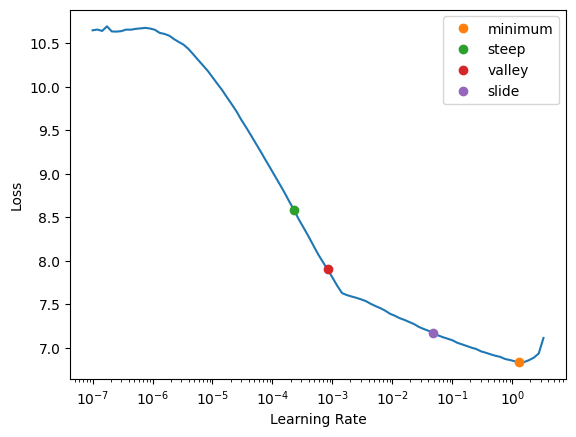

In [ ]:
res = learn.lr_find(suggest_funcs=[minimum, steep, valley, slide])


In [10]:
res

SuggestedLRs(minimum=0.13182567358016967, steep=0.0002290867705596611, valley=0.0008317637839354575, slide=0.04786301031708717)